In [67]:
def THRESHOLD(data):
    if data>=797.314:
        return 11
    elif data>=740.9375:
        return 10
    elif data>=684.5565:
        return 9
    elif data>=628.1795:
        return 8
    elif data>=571.7965:
        return 7
    elif data>=515.4215:
        return 6
    elif data>=459.045:
        return 5
    elif data>=402.6645:
        return 4
    elif data>=346.28:
        return 3
    elif data>=289/9025:
        return 2
    else:
        return 1

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
warnings.filterwarnings('ignore')
%matplotlib inline

# 경향성이 있는 그래프의 선형적으로 증가할 수 있게 하는 함수 
def trend(time, slope = 0):
    return time * slope

# x: 시간축인 함수 plot 함수
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

# 120개씩 자르는 함수 
def univariate_data(dataset, start_index, end_index):
    data = []
    history_size = 120
    start_index = start_index + history_size


    for i in range(start_index, end_index, 120): # 0
        indices = range(i - history_size, i) # [0 - 120] , [120 - 240] ...
        # Reshape data from (history_size,) to (history_size, 1)

        data.append(dataset[indices])

    return np.array(data)

for i in range(1,9):
    globals()['df_'+str(i) ]= pd.read_csv('./temperature_csv_file/temp_df_{}.csv'.format(i), encoding = 'cp949')

df_all = pd.concat([df_1, df_2], axis = 0)
df_all = pd.concat([df_all, df_3], axis = 0)
df_all = pd.concat([df_all, df_4], axis = 0)
df_all = pd.concat([df_all, df_5], axis = 0)
df_all = pd.concat([df_all, df_6], axis = 0)
df_all = pd.concat([df_all, df_7], axis = 0)
df_all = pd.concat([df_all, df_8], axis = 0)

df_all = df_all[:601800].reset_index().drop(columns = ['index'], axis = 0)

for i in range(1,8):
    globals()['df_'+str(i)+'_tmp'] = df_all[85920*(i-1):85920*i].reset_index().drop(columns=['index'], axis=0)


for i in range(1,8):
    mean = globals()['df_'+str(i)+'_tmp']['TEMP'].mean()
    diff  = 261.7292228119181 - mean
    globals()['df_'+str(i)+'_tmp']['TEMP'] += diff

for i in range(8,12):
    globals()['df_'+str(i)+'_tmp'] = globals()['df_'+str(i-5)+'_tmp'].copy()

N = 6
dx = (600 - df_1_tmp['TEMP'].mean()) / N # 전체 데이터에 대한 증가율 : 56.3785
dx_minute = dx / (len(df_1_tmp)-1) # 분당 증가율

time = np.arange(85920)
slope = dx_minute * 2

def trend(time, slope = 0):
    return time * slope

for i in range(2,12):
    series = np.round(trend(time, slope = slope) + globals()['df_'+str(i)+'_tmp']['TEMP'] + dx*(i-2), 3)
    globals()['df_'+str(i)+'_tmp']['TEMP'] = series


univariate_past_history = 120

for i in range(1,12):
    data = {'MEAN_TEMP' : [], 'STD' : [], 'MIN' : [], 'MAX' : [], 'SKEW' : [], 'KURT' : [], 'MEDIAN':[], '25%' : [], '75%' : [], 'Group' : []}

    for j in range(716):
        MEAN = np.round(globals()['df_'+str(i)+'_tmp']['TEMP'][120*j:120*(j+1)].mean(),3)
        MIN = np.min(globals()['df_'+str(i)+'_tmp']['TEMP'][120*j:120*(j+1)])
        MAX = np.max(globals()['df_'+str(i)+'_tmp']['TEMP'][120*j:120*(j+1)])
        STD = np.std(globals()['df_'+str(i)+'_tmp']['TEMP'][120*j:120*(j+1)])
        skew = globals()['df_'+str(i)+'_tmp']['TEMP'][120*j:120*(j+1)].skew()
        kurt = globals()['df_'+str(i)+'_tmp']['TEMP'][120*j:120*(j+1)].kurt()
        median = globals()['df_'+str(i)+'_tmp']['TEMP'][120*j:120*(j+1)].median()
        a, b = np.percentile(globals()['df_'+str(i)+'_tmp']['TEMP'][120*j:120*(j+1)], q=[25,75])
        data['Group'].append(i)
        data['MEAN_TEMP'].append(MEAN)
        data['MIN'].append(MIN)
        data['MAX'].append(MAX)
        data['STD'].append(STD)
        data['SKEW'].append(skew)
        data['KURT'].append(kurt)
        data['MEDIAN'].append(np.round(median,3))
        data['25%'].append(np.round(a,3))
        data['75%'].append(np.round(b,3))

    globals()['group_'+str(i)] = pd.DataFrame(data)

TIME = pd.DataFrame({'TIME' : np.arange(7876)})
tmp = pd.concat([group_1, group_2], axis = 0)
tmp = pd.concat([tmp, group_3], axis = 0)
tmp = pd.concat([tmp, group_4], axis = 0)
tmp = pd.concat([tmp, group_5], axis = 0)
tmp = pd.concat([tmp, group_6], axis = 0)
tmp = pd.concat([tmp, group_7], axis = 0)
tmp = pd.concat([tmp, group_8], axis = 0)
tmp = pd.concat([tmp, group_9], axis = 0)
tmp = pd.concat([tmp, group_10], axis = 0)
tmp = pd.concat([tmp, group_11], axis = 0)
tmp = tmp.reset_index()
tmp = pd.concat([tmp, TIME], axis = 1)
tmp.drop(columns = ['index'], inplace = True)
df = tmp

for i in range(1,12):
    globals()['df_temp_'+str(i)] = univariate_data(globals()['df_'+str(i)+'_tmp']['TEMP'], 0, len(df_1_tmp)+1)

from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
X = df.iloc[:, :9].values
X_mean = df['MEAN_TEMP'].values
y = df['Group'].values - 1
X_mean = X_mean.reshape(X_mean.shape[0], 1)

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

scaler = MinMaxScaler()
X_scale = scaler.fit_transform(X)
X_mean_scale = scaler.fit_transform(X_mean)
e = LabelEncoder()
Y = e.fit_transform(y)
Y = tf.keras.utils.to_categorical(Y)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 96)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
df

(6300, 9) (1576, 9) (6300,) (1576,)


,MEAN_TEMP,STD,MIN,MAX,SKEW,KURT,MEDIAN,25%,75%,Group,TIME
0,284.192,1.275722,281.401,287.082,0.295874,-0.637850,283.830,283.258,285.130,1,0
1,284.353,1.052731,281.236,286.949,-0.106596,0.698932,284.267,283.797,284.914,1,1
2,285.276,1.043551,282.941,287.552,-0.194906,-0.650376,285.382,284.480,286.067,1,2
3,285.589,0.970639,283.867,288.153,0.674937,-0.078318,285.392,284.831,286.155,1,3
4,285.146,1.074865,281.689,286.664,-1.387162,1.773495,285.408,284.652,285.868,1,4
...,...,...,...,...,...,...,...,...,...,...,...
7871,931.874,2.127380,926.730,936.100,0.082092,-0.390703,931.289,930.506,933.720,11,7871
7872,933.001,0.585021,931.564,934.166,-0.247556,-0.619292,933.079,932.608,933.400,11,7872
7873,933.236,0.659152,931.690,934.549,-0.459517,-0.417622,933.340,932.907,933.744,11,7873
7874,933.649,0.771575,932.209,935.319,0.079975,-1.172105,933.754,932.942,934.268,11,7874


In [69]:
X = df['MEAN_TEMP'].values
Y = df['Group'].values

predict = list(map(THRESHOLD, X))
print(accuracy_score(predict, Y))

0.38981005018740866


In [3]:
df_all = pd.concat([df_1, df_2], axis = 0)
df_all = pd.concat([df_all, df_3], axis = 0)
df_all = pd.concat([df_all, df_4], axis = 0)
df_all = pd.concat([df_all, df_5], axis = 0)
df_all = pd.concat([df_all, df_6], axis = 0)
df_all = pd.concat([df_all, df_7], axis = 0)
df_all = pd.concat([df_all, df_8], axis = 0)
df_all = df_all.reset_index().drop(columns = ['index', 'kst'], axis = 0)
df_all

,date,TEMP
0,20230101,286.797
1,20230101,287.082
2,20230101,285.938
3,20230101,285.772
4,20230101,286.357
...,...,...
601887,20230801,280.894
601888,20230801,280.625
601889,20230801,280.475
601890,20230801,280.545


In [4]:
601892 // 60, 601892 % 60

(10031, 32)

In [5]:
10031 * 60

601860

In [6]:

for i in range(1,8):
    globals()['df_'+str(i)+'_tmp'] = df_all[10031*(i-1):10031*i].reset_index().drop(columns=['index'], axis=0)

## Window size : 120, Stride : 60

In [66]:
for i in range(1,8):
    globals()['df_'+str(i)+'_tmp'] = df_all[85920*(i-1):85920*i].reset_index().drop(columns=['index'], axis=0)


for i in range(1,8):
    mean = globals()['df_'+str(i)+'_tmp']['TEMP'].mean()
    diff  = 261.7292228119181 - mean
    globals()['df_'+str(i)+'_tmp']['TEMP'] += diff

for i in range(8,12):
    globals()['df_'+str(i)+'_tmp'] = globals()['df_'+str(i-5)+'_tmp'].copy()

for i in range(2,12):
    series = np.round(trend(time, slope = slope) + globals()['df_'+str(i)+'_tmp']['TEMP'] + dx*(i-2), 3)
    globals()['df_'+str(i)+'_tmp']['TEMP'] = series

for i in range(1,12):
    data = {'MEAN_TEMP' : [], 'STD' : [], 'MIN' : [], 'MAX' : [], 'SKEW' : [], 'KURT' : [], 'MEDIAN':[], '25%' : [], '75%' : [], 'Group' : []}

    for j in range(0,85801,60):
        temp = globals()['df_'+str(i)+'_tmp']['TEMP'][j:j+120]
        MEAN = np.round(np.mean(temp), 3)
        MIN = np.min(temp)
        MAX = np.max(temp)
        STD = np.std(temp)
        skew = temp.skew()
        kurt = temp.kurt()
        a, b = np.percentile(temp, q = [25,75])

        data['Group'].append(i)
        data['MEAN_TEMP'].append(MEAN)
        data['MIN'].append(MIN)
        data['MAX'].append(MAX)
        data['STD'].append(STD)
        data['SKEW'].append(skew)
        data['KURT'].append(kurt)
        data['MEDIAN'].append(np.round(median,3))
        data['25%'].append(np.round(a,3))
        data['75%'].append(np.round(b,3))

    globals()['group_'+str(i)] = pd.DataFrame(data)

TIME = pd.DataFrame({'TIME' : np.arange(15741)})
tmp = pd.concat([group_1, group_2], axis = 0)
tmp = pd.concat([tmp, group_3], axis = 0)
tmp = pd.concat([tmp, group_4], axis = 0)
tmp = pd.concat([tmp, group_5], axis = 0)
tmp = pd.concat([tmp, group_6], axis = 0)
tmp = pd.concat([tmp, group_7], axis = 0)
tmp = pd.concat([tmp, group_8], axis = 0)
tmp = pd.concat([tmp, group_9], axis = 0)
tmp = pd.concat([tmp, group_10], axis = 0)
tmp = pd.concat([tmp, group_11], axis = 0)
tmp = tmp.reset_index()
tmp = pd.concat([tmp, TIME], axis = 1)
tmp.drop(columns = ['index'], inplace = True)
df = tmp

In [8]:
df

,MEAN_TEMP,STD,MIN,MAX,SKEW,KURT,MEDIAN,25%,75%,Group,TIME
0,284.192,1.275722,281.401,287.082,0.295874,-0.637850,933.649,283.258,285.130,1,0
1,284.353,1.075364,282.258,286.949,0.285079,-0.405549,933.649,283.639,285.074,1,1
2,284.353,1.052731,281.236,286.949,-0.106596,0.698932,933.649,283.797,284.914,1,2
3,284.929,1.196956,281.236,287.552,-0.350329,0.298880,933.649,284.118,285.819,1,3
4,285.276,1.043551,282.941,287.552,-0.194906,-0.650376,933.649,284.480,286.067,1,4
...,...,...,...,...,...,...,...,...,...,...,...
15736,933.236,0.659152,931.690,934.549,-0.459517,-0.417622,933.649,932.907,933.744,11,15736
15737,933.374,0.542534,932.209,934.549,0.042072,-0.972253,933.649,932.924,933.818,11,15737
15738,933.649,0.771575,932.209,935.319,0.079975,-1.172105,933.649,932.942,934.268,11,15738
15739,934.024,0.554419,932.681,935.378,0.106393,-0.278596,933.649,933.663,934.451,11,15739


In [68]:
X = df['MEAN_TEMP'].values
Y = df['Group'].values

predict = list(map(THRESHOLD, X))
print(accuracy_score(predict, Y))

0.38981005018740866


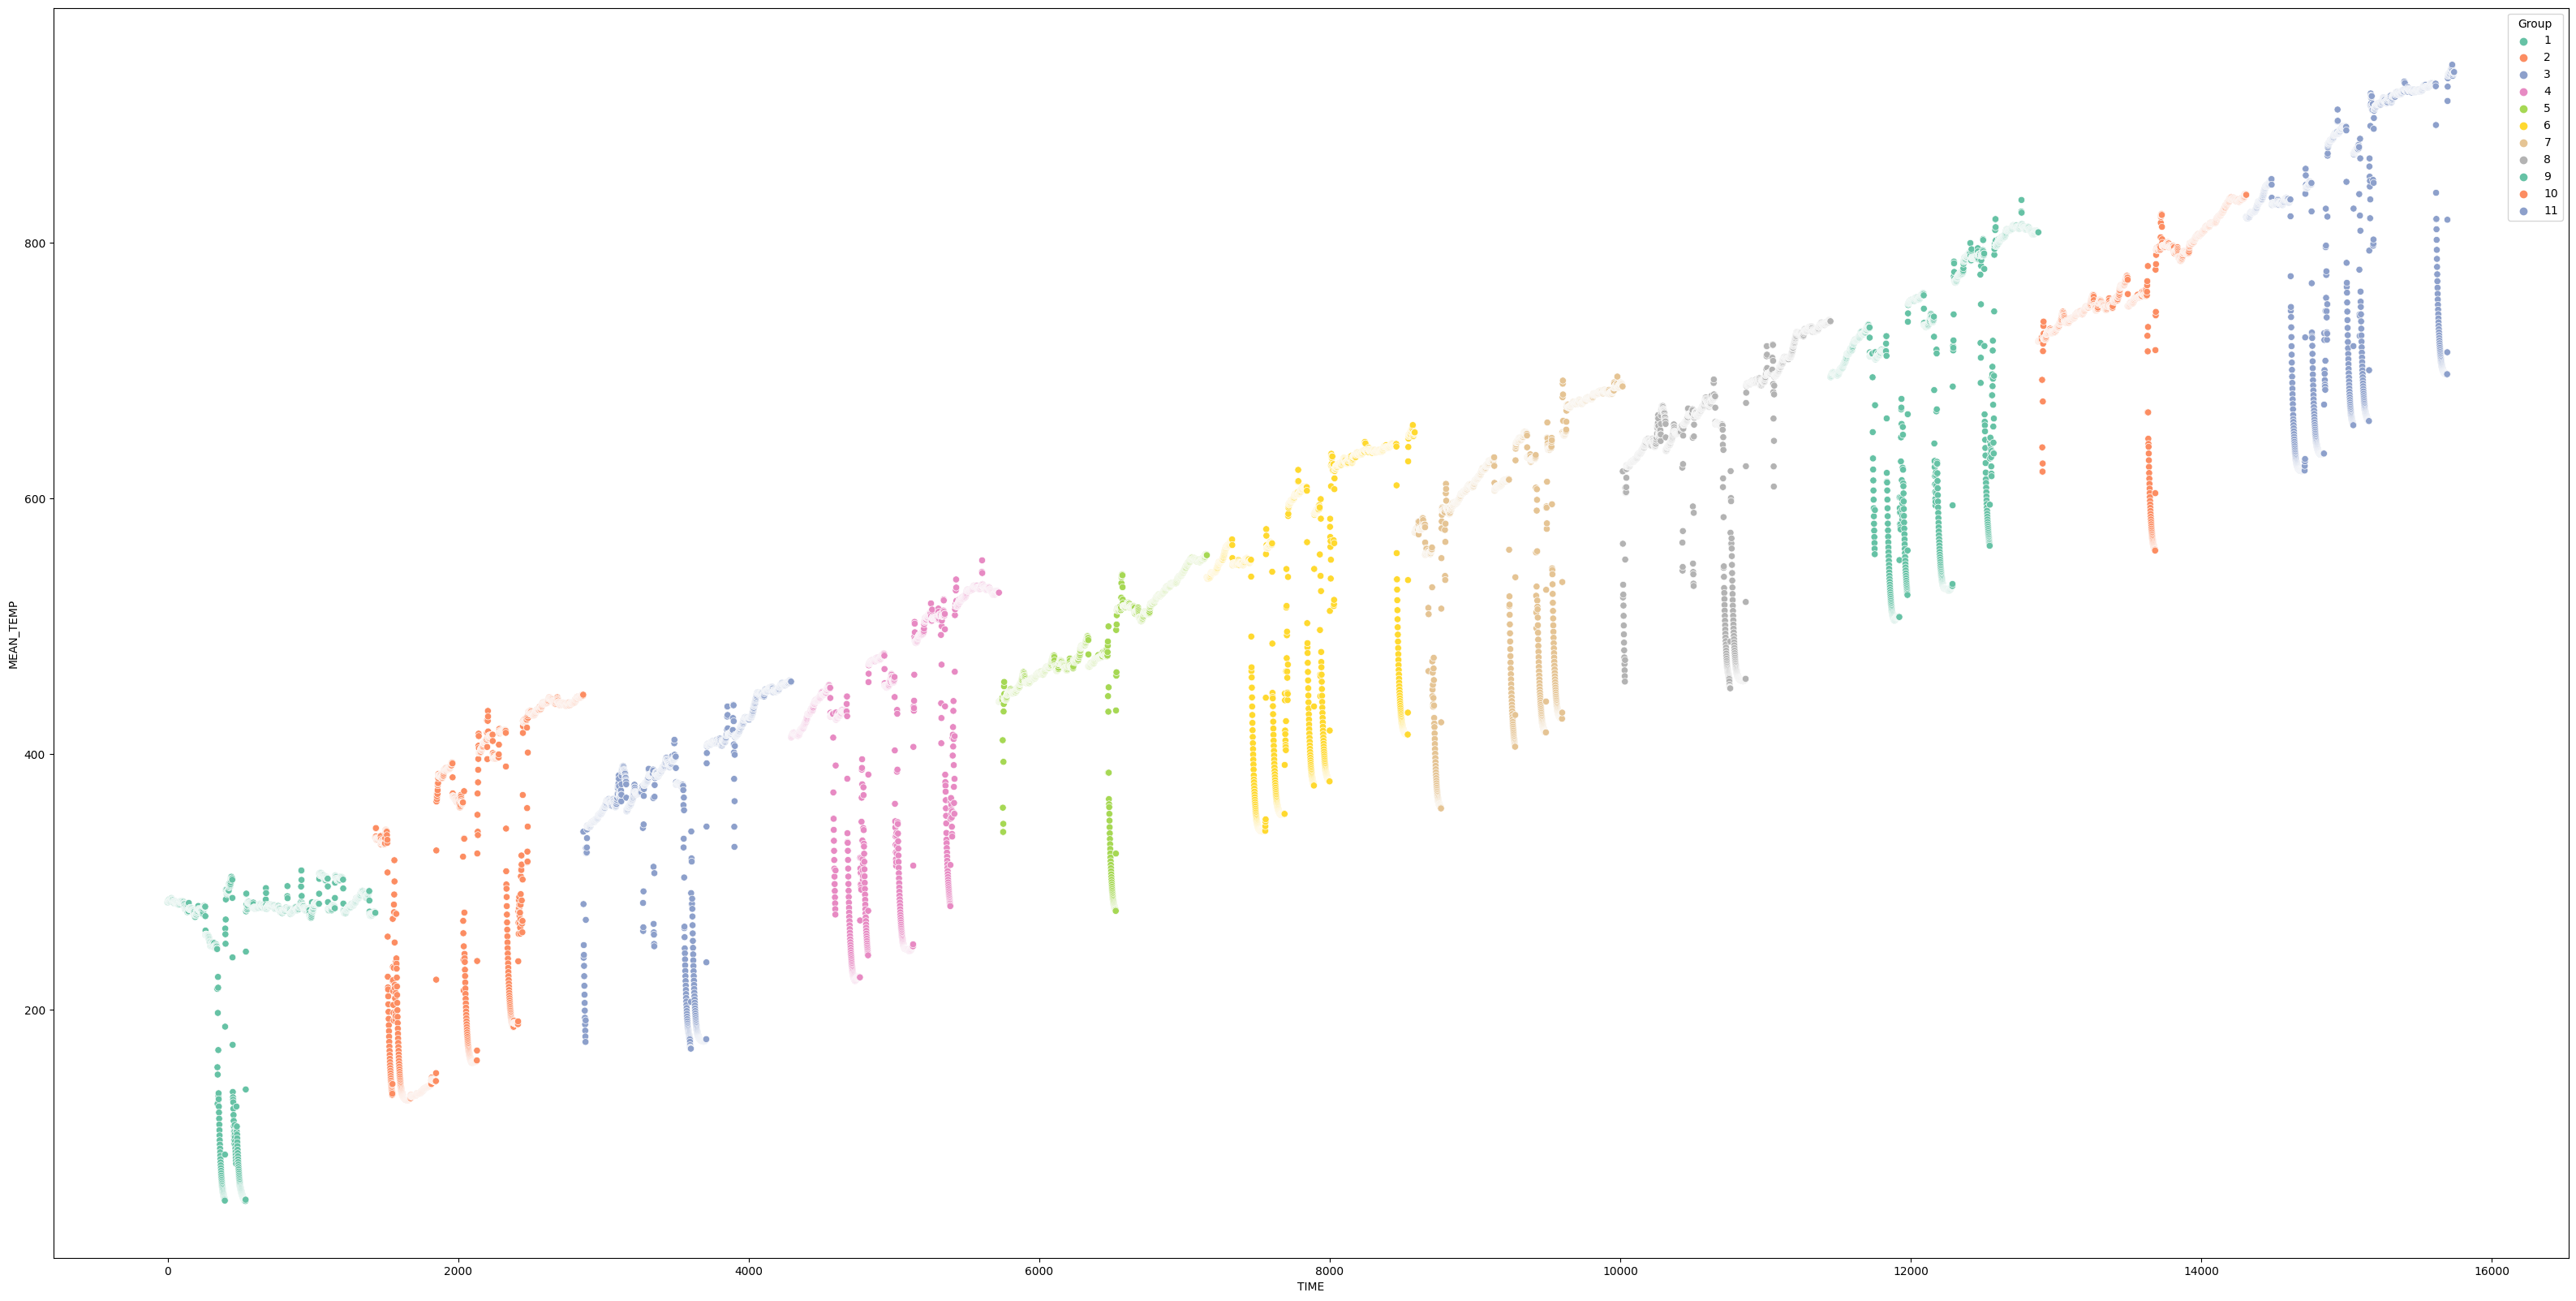

In [9]:
plt.figure(figsize = (40,20))
sns.scatterplot(data = df, x = 'TIME', y = 'MEAN_TEMP', hue = 'Group', palette='Set2')
plt.show()

In [10]:
df

,MEAN_TEMP,STD,MIN,MAX,SKEW,KURT,MEDIAN,25%,75%,Group,TIME
0,284.192,1.275722,281.401,287.082,0.295874,-0.637850,933.649,283.258,285.130,1,0
1,284.353,1.075364,282.258,286.949,0.285079,-0.405549,933.649,283.639,285.074,1,1
2,284.353,1.052731,281.236,286.949,-0.106596,0.698932,933.649,283.797,284.914,1,2
3,284.929,1.196956,281.236,287.552,-0.350329,0.298880,933.649,284.118,285.819,1,3
4,285.276,1.043551,282.941,287.552,-0.194906,-0.650376,933.649,284.480,286.067,1,4
...,...,...,...,...,...,...,...,...,...,...,...
15736,933.236,0.659152,931.690,934.549,-0.459517,-0.417622,933.649,932.907,933.744,11,15736
15737,933.374,0.542534,932.209,934.549,0.042072,-0.972253,933.649,932.924,933.818,11,15737
15738,933.649,0.771575,932.209,935.319,0.079975,-1.172105,933.649,932.942,934.268,11,15738
15739,934.024,0.554419,932.681,935.378,0.106393,-0.278596,933.649,933.663,934.451,11,15739


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X = df.iloc[:, :9].values
y = df['Group'].values


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 96)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(12592, 9) (3149, 9) (12592,) (3149,)


In [12]:
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier(n_estimators = 50)

lgbm.fit(X_train, y_train,
         eval_metric = 'multi_logloss',
         eval_set = [(X_test, y_test)])
lgbm_predict = lgbm.predict(X_test)
print(accuracy_score(y_test, lgbm_predict))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 12592, number of used features: 8
[LightGBM] [Info] Start training from score -2.413502
[LightGBM] [Info] Start training from score -2.389828
[LightGBM] [Info] Start training from score -2.390694
[LightGBM] [Info] Start training from score -2.423311
[LightGBM] [Info] Start training from score -2.398531
[LightGBM] [Info] Start training from score -2.392431
[LightGBM] [Info] Start training from score -2.395912
[LightGBM] [Info] Start training from score -2.394170
[LightGBM] [Info] Start training from score -2.402911
[LightGBM] [Info] Start training from score -2.409959
[LightGBM] [Info] Start training from score -2.366700
0.7894569704668148


In [13]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 11)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
print(accuracy_score(y_test, knn_pred))

0.7329310892346776


In [14]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state = 42)

dtc.fit(X_train, y_train)
dtc_pred = dtc.predict(X_test)
print(accuracy_score(y_test, dtc_pred))

0.7770720863766275


In [15]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, max_depth = 50, random_state = 96)
clf.fit(X_train, y_train)

clf_predict = clf.predict(X_test)
print(accuracy_score(clf_predict, y_test))

0.8189901556049539


## 사람이 판단 하는 if 문

In [16]:
def THRESHOLD(data):
    if data>=797.314:
        return 11
    elif data>=740.9375:
        return 10
    elif data>=684.5565:
        return 9
    elif data>=628.1795:
        return 8
    elif data>=571.7965:
        return 7
    elif data>=515.4215:
        return 6
    elif data>=459.045:
        return 5
    elif data>=402.6645:
        return 4
    elif data>=346.28:
        return 3
    elif data>=289/9025:
        return 2
    else:
        return 1

## Window size : 240, Stride : 0

In [70]:
for i in range(1,8):
    globals()['df_'+str(i)+'_tmp'] = df_all[85920*(i-1):85920*i].reset_index().drop(columns=['index'], axis=0)


for i in range(1,8):
    mean = globals()['df_'+str(i)+'_tmp']['TEMP'].mean()
    diff  = 261.7292228119181 - mean
    globals()['df_'+str(i)+'_tmp']['TEMP'] += diff

for i in range(8,12):
    globals()['df_'+str(i)+'_tmp'] = globals()['df_'+str(i-5)+'_tmp'].copy()

for i in range(2,12):
    series = np.round(trend(time, slope = slope) + globals()['df_'+str(i)+'_tmp']['TEMP'] + dx*(i-2), 3)
    globals()['df_'+str(i)+'_tmp']['TEMP'] = series

for i in range(1,12):
    data = {'MEAN_TEMP' : [], 'STD' : [], 'MIN' : [], 'MAX' : [], 'SKEW' : [], 'KURT' : [], 'MEDIAN':[], '25%' : [], '75%' : [], 'Group' : []}

    for j in range(358):
        tmp = globals()['df_'+str(i)+'_tmp']['TEMP'][240*j:240*(j+1)]
        MEAN = np.round(tmp.mean(),3)
        MIN = np.min(tmp)
        MAX = np.max(tmp)
        STD = np.std(tmp)
        skew = tmp.skew()
        kurt = tmp.kurt()
        median = tmp.median()
        a, b = np.percentile(tmp, q=[25,75])
        data['Group'].append(i)
        data['MEAN_TEMP'].append(MEAN)
        data['MIN'].append(MIN)
        data['MAX'].append(MAX)
        data['STD'].append(STD)
        data['SKEW'].append(skew)
        data['KURT'].append(kurt)
        data['MEDIAN'].append(np.round(median,3))
        data['25%'].append(np.round(a,3))
        data['75%'].append(np.round(b,3))

    globals()['group_'+str(i)] = pd.DataFrame(data)
    
print(len(group_1))
TIME = pd.DataFrame({'TIME' : np.arange(3938)})
tmp = pd.concat([group_1, group_2], axis = 0)
tmp = pd.concat([tmp, group_3], axis = 0)
tmp = pd.concat([tmp, group_4], axis = 0)
tmp = pd.concat([tmp, group_5], axis = 0)
tmp = pd.concat([tmp, group_6], axis = 0)
tmp = pd.concat([tmp, group_7], axis = 0)
tmp = pd.concat([tmp, group_8], axis = 0)
tmp = pd.concat([tmp, group_9], axis = 0)
tmp = pd.concat([tmp, group_10], axis = 0)
tmp = pd.concat([tmp, group_11], axis = 0)
tmp = tmp.reset_index()
tmp = pd.concat([tmp, TIME], axis = 1)
tmp.drop(columns = ['index'], inplace = True)
df = tmp

358


In [71]:
df

,MEAN_TEMP,STD,MIN,MAX,SKEW,KURT,MEDIAN,25%,75%,Group,TIME
0,284.273,1.172316,281.236,287.082,0.111951,-0.196105,284.128,283.493,285.043,1,0
1,285.432,1.019847,282.941,288.153,0.152628,-0.144639,285.392,284.711,286.104,1,1
2,285.157,0.998868,281.689,287.936,-0.813130,1.233742,285.333,284.595,285.822,1,2
3,285.740,1.298405,283.557,289.396,0.608780,-0.242441,285.558,284.747,286.430,1,3
4,284.968,0.878387,282.933,288.385,0.344808,0.910145,285.005,284.323,285.506,1,4
...,...,...,...,...,...,...,...,...,...,...,...
3933,935.805,0.596340,934.152,937.272,-0.102963,-0.498508,935.803,935.352,936.281,11,3933
3934,936.476,8.700383,930.177,969.548,2.607087,5.911863,935.089,931.487,935.813,11,3934
3935,931.510,1.581461,926.730,936.100,0.692504,1.691038,931.216,930.761,931.759,11,3935
3936,933.119,0.634135,931.564,934.549,-0.288932,-0.562869,933.154,932.717,933.586,11,3936


In [72]:
X = df['MEAN_TEMP'].values
Y = df['Group'].values

predict = list(map(THRESHOLD, X))
print(accuracy_score(predict, Y))

0.3900457084814627


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier

X = df.iloc[:, :9].values
y = df['Group'].values


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 96)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

lgbm = LGBMClassifier(n_estimators = 50)

lgbm.fit(X_train, y_train,
         eval_metric = 'multi_logloss',
         eval_set = [(X_test, y_test)])
lgbm_predict = lgbm.predict(X_test)
print(accuracy_score(y_test, lgbm_predict))

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 11)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
print(accuracy_score(y_test, knn_pred))

from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state = 42)

dtc.fit(X_train, y_train)
dtc_pred = dtc.predict(X_test)
print(accuracy_score(y_test, dtc_pred))

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, max_depth = 50, random_state = 96)
clf.fit(X_train, y_train)

clf_predict = clf.predict(X_test)
print(accuracy_score(clf_predict, y_test))

(3150, 9) (788, 9) (3150,) (788,)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 3150, number of used features: 9
[LightGBM] [Info] Start training from score -2.416803
[LightGBM] [Info] Start training from score -2.388731
[LightGBM] [Info] Start training from score -2.399166
[LightGBM] [Info] Start training from score -2.406183
[LightGBM] [Info] Start training from score -2.409711
[LightGBM] [Info] Start training from score -2.371578
[LightGBM] [Info] Start training from score -2.385277
[LightGBM] [Info] Start training from score -2.385277
[LightGBM] [Info] Start training from score -2.392197
[LightGBM] [Info] Start training from score -2.409711
[LightGBM] [Info] Start training from score -2.413251
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

## Window size : 240, Stirde : 80

In [20]:
85680 // 160, 160*535

(535, 85600)

In [73]:
for i in range(1,8):
    globals()['df_'+str(i)+'_tmp'] = df_all[85920*(i-1):85920*i].reset_index().drop(columns=['index'], axis=0)


for i in range(1,8):
    mean = globals()['df_'+str(i)+'_tmp']['TEMP'].mean()
    diff  = 261.7292228119181 - mean
    globals()['df_'+str(i)+'_tmp']['TEMP'] += diff

for i in range(8,12):
    globals()['df_'+str(i)+'_tmp'] = globals()['df_'+str(i-5)+'_tmp'].copy()

for i in range(2,12):
    series = np.round(trend(time, slope = slope) + globals()['df_'+str(i)+'_tmp']['TEMP'] + dx*(i-2), 3)
    globals()['df_'+str(i)+'_tmp']['TEMP'] = series

for i in range(1,12):
    data = {'MEAN_TEMP' : [], 'STD' : [], 'MIN' : [], 'MAX' : [], 'SKEW' : [], 'KURT' : [], 'MEDIAN':[], '25%' : [], '75%' : [], 'Group' : []}

    for j in range(0,85601,160):
        temp = globals()['df_'+str(i)+'_tmp']['TEMP'][j:j+240]
        MEAN = np.round(np.mean(temp), 3)
        MIN = np.min(temp)
        MAX = np.max(temp)
        STD = np.std(temp)
        skew = temp.skew()
        kurt = temp.kurt()
        a, b = np.percentile(temp, q = [25,75])

        data['Group'].append(i)
        data['MEAN_TEMP'].append(MEAN)
        data['MIN'].append(MIN)
        data['MAX'].append(MAX)
        data['STD'].append(STD)
        data['SKEW'].append(skew)
        data['KURT'].append(kurt)
        data['MEDIAN'].append(np.round(median,3))
        data['25%'].append(np.round(a,3))
        data['75%'].append(np.round(b,3))

    globals()['group_'+str(i)] = pd.DataFrame(data)


print(len(group_1))
TIME = pd.DataFrame({'TIME' : np.arange(5896)})
tmp = pd.concat([group_1, group_2], axis = 0)
tmp = pd.concat([tmp, group_3], axis = 0)
tmp = pd.concat([tmp, group_4], axis = 0)
tmp = pd.concat([tmp, group_5], axis = 0)
tmp = pd.concat([tmp, group_6], axis = 0)
tmp = pd.concat([tmp, group_7], axis = 0)
tmp = pd.concat([tmp, group_8], axis = 0)
tmp = pd.concat([tmp, group_9], axis = 0)
tmp = pd.concat([tmp, group_10], axis = 0)
tmp = pd.concat([tmp, group_11], axis = 0)
tmp = tmp.reset_index()
tmp = pd.concat([tmp, TIME], axis = 1)
tmp.drop(columns = ['index'], inplace = True)
df = tmp

536


In [74]:
df

,MEAN_TEMP,STD,MIN,MAX,SKEW,KURT,MEDIAN,25%,75%,Group,TIME
0,284.273,1.172316,281.236,287.082,0.111951,-0.196105,933.663,283.493,285.043,1,0
1,284.932,1.043099,281.236,287.552,-0.254982,0.503587,933.663,284.232,285.621,1,1
2,285.247,1.101415,281.689,288.153,-0.287471,1.025162,933.663,284.589,285.922,1,2
3,285.157,0.998868,281.689,287.936,-0.813130,1.233742,933.663,284.595,285.822,1,3
4,285.670,1.329734,283.416,289.396,0.656001,-0.236257,933.663,284.588,286.375,1,4
...,...,...,...,...,...,...,...,...,...,...,...
5891,936.476,8.700383,930.177,969.548,2.607087,5.911863,933.663,931.487,935.813,11,5891
5892,931.173,0.500535,929.610,932.561,-0.051022,0.408013,933.663,930.852,931.472,11,5892
5893,932.185,1.701036,926.730,936.100,-0.289339,0.422678,933.663,931.031,933.400,11,5893
5894,933.119,0.634135,931.564,934.549,-0.288932,-0.562869,933.663,932.717,933.586,11,5894


In [76]:
X = df['MEAN_TEMP'].values
Y = df['Group'].values

predict = list(map(THRESHOLD, X))
print(accuracy_score(predict, Y))

0.38975576662143824


In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier

X = df.iloc[:, :9].values
y = df['Group'].values


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 96)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

lgbm = LGBMClassifier(n_estimators = 50)

lgbm.fit(X_train, y_train,
         eval_metric = 'multi_logloss',
         eval_set = [(X_test, y_test)])
lgbm_predict = lgbm.predict(X_test)
print("LGBM ", accuracy_score(y_test, lgbm_predict))

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 11)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
print("KN", accuracy_score(y_test, knn_pred))

from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state = 42)

dtc.fit(X_train, y_train)
dtc_pred = dtc.predict(X_test)
print("DTC", accuracy_score(y_test, dtc_pred))

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, max_depth = 50, random_state = 96)
clf.fit(X_train, y_train)

clf_predict = clf.predict(X_test)
print("RFC", accuracy_score(clf_predict, y_test))

(4716, 9) (1180, 9) (4716,) (1180,)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 4716, number of used features: 8
[LightGBM] [Info] Start training from score -2.406627
[LightGBM] [Info] Start training from score -2.408983
[LightGBM] [Info] Start training from score -2.401932
[LightGBM] [Info] Start training from score -2.428031
[LightGBM] [Info] Start training from score -2.365146
[LightGBM] [Info] Start training from score -2.437693
[LightGBM] [Info] Start training from score -2.360642
[LightGBM] [Info] Start training from score -2.394931
[LightGBM] [Info] Start training from score -2.378783
[LightGBM] [Info] Start training from score -2.378783
[LightGBM] [Info] Start training from score -2.418462
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

## Window : 240, Stride : 120

In [24]:
85680 // 120, 716*120

(714, 85920)

In [77]:
for i in range(1,8):
    globals()['df_'+str(i)+'_tmp'] = df_all[85920*(i-1):85920*i].reset_index().drop(columns=['index'], axis=0)


for i in range(1,8):
    mean = globals()['df_'+str(i)+'_tmp']['TEMP'].mean()
    diff  = 261.7292228119181 - mean
    globals()['df_'+str(i)+'_tmp']['TEMP'] += diff

for i in range(8,12):
    globals()['df_'+str(i)+'_tmp'] = globals()['df_'+str(i-5)+'_tmp'].copy()

for i in range(2,12):
    series = np.round(trend(time, slope = slope) + globals()['df_'+str(i)+'_tmp']['TEMP'] + dx*(i-2), 3)
    globals()['df_'+str(i)+'_tmp']['TEMP'] = series

for i in range(1,12):
    data = {'MEAN_TEMP' : [], 'STD' : [], 'MIN' : [], 'MAX' : [], 'SKEW' : [], 'KURT' : [], 'MEDIAN':[], '25%' : [], '75%' : [], 'Group' : []}

    for j in range(0,85681,120):
        temp = globals()['df_'+str(i)+'_tmp']['TEMP'][j:j+240]
        MEAN = np.round(np.mean(temp), 3)
        MIN = np.min(temp)
        MAX = np.max(temp)
        STD = np.std(temp)
        skew = temp.skew()
        kurt = temp.kurt()
        a, b = np.percentile(temp, q = [25,75])

        data['Group'].append(i)
        data['MEAN_TEMP'].append(MEAN)
        data['MIN'].append(MIN)
        data['MAX'].append(MAX)
        data['STD'].append(STD)
        data['SKEW'].append(skew)
        data['KURT'].append(kurt)
        data['MEDIAN'].append(np.round(median,3))
        data['25%'].append(np.round(a,3))
        data['75%'].append(np.round(b,3))

    globals()['group_'+str(i)] = pd.DataFrame(data)


print(len(group_1))
TIME = pd.DataFrame({'TIME' : np.arange(7865)})
tmp = pd.concat([group_1, group_2], axis = 0)
tmp = pd.concat([tmp, group_3], axis = 0)
tmp = pd.concat([tmp, group_4], axis = 0)
tmp = pd.concat([tmp, group_5], axis = 0)
tmp = pd.concat([tmp, group_6], axis = 0)
tmp = pd.concat([tmp, group_7], axis = 0)
tmp = pd.concat([tmp, group_8], axis = 0)
tmp = pd.concat([tmp, group_9], axis = 0)
tmp = pd.concat([tmp, group_10], axis = 0)
tmp = pd.concat([tmp, group_11], axis = 0)
tmp = tmp.reset_index()
tmp = pd.concat([tmp, TIME], axis = 1)
tmp.drop(columns = ['index'], inplace = True)
df = tmp
df



715


,MEAN_TEMP,STD,MIN,MAX,SKEW,KURT,MEDIAN,25%,75%,Group,TIME
0,284.273,1.172316,281.236,287.082,0.111951,-0.196105,933.663,283.493,285.043,1,0
1,284.814,1.145222,281.236,287.552,-0.123329,-0.091514,933.663,284.032,285.621,1,1
2,285.432,1.019847,282.941,288.153,0.152628,-0.144639,933.663,284.711,286.104,1,2
3,285.368,1.047729,281.689,288.153,-0.539453,1.803823,933.663,284.776,285.975,1,3
4,285.157,0.998868,281.689,287.936,-0.813130,1.233742,933.663,284.595,285.822,1,4
...,...,...,...,...,...,...,...,...,...,...,...
7860,931.510,1.581461,926.730,936.100,0.692504,1.691038,933.663,930.761,931.759,11,7860
7861,932.438,1.658737,926.730,936.100,-0.698888,1.051691,933.663,931.296,933.453,11,7861
7862,933.119,0.634135,931.564,934.549,-0.288932,-0.562869,933.663,932.717,933.586,11,7862
7863,933.443,0.746763,931.690,935.319,0.007365,-0.519426,933.663,932.914,934.017,11,7863


In [78]:
X = df['MEAN_TEMP'].values
Y = df['Group'].values

predict = list(map(THRESHOLD, X))
print(accuracy_score(predict, Y))

0.389446916719644


In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier

X = df.iloc[:, :9].values
y = df['Group'].values


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 96)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

lgbm = LGBMClassifier(n_estimators = 50)

lgbm.fit(X_train, y_train,
         eval_metric = 'multi_logloss',
         eval_set = [(X_test, y_test)])
lgbm_predict = lgbm.predict(X_test)
print("LGBM ", accuracy_score(y_test, lgbm_predict))

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 11)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
print("KN", accuracy_score(y_test, knn_pred))

from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state = 42)

dtc.fit(X_train, y_train)
dtc_pred = dtc.predict(X_test)
print("DTC", accuracy_score(y_test, dtc_pred))

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, max_depth = 50, random_state = 96)
clf.fit(X_train, y_train)

clf_predict = clf.predict(X_test)
print("RFC", accuracy_score(clf_predict, y_test))

(6292, 9) (1573, 9) (6292,) (1573,)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 6292, number of used features: 8
[LightGBM] [Info] Start training from score -2.394405
[LightGBM] [Info] Start training from score -2.389192
[LightGBM] [Info] Start training from score -2.401398
[LightGBM] [Info] Start training from score -2.401398
[LightGBM] [Info] Start training from score -2.410209
[LightGBM] [Info] Start training from score -2.428066
[LightGBM] [Info] Start training from score -2.355117
[LightGBM] [Info] Start training from score -2.426266
[LightGBM] [Info] Start training from score -2.403154
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.372009
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LGBM  0.

In [58]:
X = df['MEAN_TEMP'].values
Y = df['Group'].values

predict = list(map(THRESHOLD, X))
print(accuracy_score(predict, Y))

0.389446916719644


In [59]:
len(X), len(Y)

(7865, 7865)

## Win : 120, Stride : 40

In [27]:
85800 // 80, 1072*80

(1072, 85760)

In [28]:
for i in range(1,8):
    globals()['df_'+str(i)+'_tmp'] = df_all[85920*(i-1):85920*i].reset_index().drop(columns=['index'], axis=0)


for i in range(1,8):
    mean = globals()['df_'+str(i)+'_tmp']['TEMP'].mean()
    diff  = 261.7292228119181 - mean
    globals()['df_'+str(i)+'_tmp']['TEMP'] += diff

for i in range(8,12):
    globals()['df_'+str(i)+'_tmp'] = globals()['df_'+str(i-5)+'_tmp'].copy()

for i in range(2,12):
    series = np.round(trend(time, slope = slope) + globals()['df_'+str(i)+'_tmp']['TEMP'] + dx*(i-2), 3)
    globals()['df_'+str(i)+'_tmp']['TEMP'] = series

for i in range(1,12):
    data = {'MEAN_TEMP' : [], 'STD' : [], 'MIN' : [], 'MAX' : [], 'SKEW' : [], 'KURT' : [], 'MEDIAN':[], '25%' : [], '75%' : [], 'Group' : []}

    for j in range(0,85800,80):
        temp = globals()['df_'+str(i)+'_tmp']['TEMP'][j:j+120]
        MEAN = np.round(np.mean(temp), 3)
        MIN = np.min(temp)
        MAX = np.max(temp)
        STD = np.std(temp)
        skew = temp.skew()
        kurt = temp.kurt()
        a, b = np.percentile(temp, q = [25,75])

        data['Group'].append(i)
        data['MEAN_TEMP'].append(MEAN)
        data['MIN'].append(MIN)
        data['MAX'].append(MAX)
        data['STD'].append(STD)
        data['SKEW'].append(skew)
        data['KURT'].append(kurt)
        data['MEDIAN'].append(np.round(median,3))
        data['25%'].append(np.round(a,3))
        data['75%'].append(np.round(b,3))

    globals()['group_'+str(i)] = pd.DataFrame(data)


TIME = pd.DataFrame({'TIME' : np.arange(11803)})
tmp = pd.concat([group_1, group_2], axis = 0)
tmp = pd.concat([tmp, group_3], axis = 0)
tmp = pd.concat([tmp, group_4], axis = 0)
tmp = pd.concat([tmp, group_5], axis = 0)
tmp = pd.concat([tmp, group_6], axis = 0)
tmp = pd.concat([tmp, group_7], axis = 0)
tmp = pd.concat([tmp, group_8], axis = 0)
tmp = pd.concat([tmp, group_9], axis = 0)
tmp = pd.concat([tmp, group_10], axis = 0)
tmp = pd.concat([tmp, group_11], axis = 0)
tmp = tmp.reset_index()
tmp = pd.concat([tmp, TIME], axis = 1)
tmp.drop(columns = ['index'], inplace = True)
df = tmp
df

,MEAN_TEMP,STD,MIN,MAX,SKEW,KURT,MEDIAN,25%,75%,Group,TIME
0,284.192,1.275722,281.401,287.082,0.295874,-0.637850,933.663,283.258,285.130,1,0
1,284.428,1.010829,282.258,286.949,0.293857,-0.069154,933.663,283.797,285.074,1,1
2,284.721,1.106552,281.236,287.552,-0.213881,0.713380,933.663,284.061,285.482,1,2
3,285.276,1.043551,282.941,287.552,-0.194906,-0.650376,933.663,284.480,286.067,1,3
4,285.323,1.071320,283.229,288.153,0.699337,0.203604,933.663,284.525,285.857,1,4
...,...,...,...,...,...,...,...,...,...,...,...
11798,933.001,0.585021,931.564,934.166,-0.247556,-0.619292,933.663,932.608,933.400,11,11798
11799,932.873,0.572203,931.564,933.912,-0.394616,-0.764075,933.663,932.422,933.340,11,11799
11800,933.303,0.542680,932.008,934.549,-0.034819,-0.399261,933.663,932.921,933.726,11,11800
11801,933.649,0.771575,932.209,935.319,0.079975,-1.172105,933.663,932.942,934.268,11,11801


In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier

X = df.iloc[:, :9].values
y = df['Group'].values


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 96)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

lgbm = LGBMClassifier(n_estimators = 50)

lgbm.fit(X_train, y_train,
         eval_metric = 'multi_logloss',
         eval_set = [(X_test, y_test)])
lgbm_predict = lgbm.predict(X_test)
print("LGBM ", accuracy_score(y_test, lgbm_predict))

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 11)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
print("KN", accuracy_score(y_test, knn_pred))

from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state = 42)

dtc.fit(X_train, y_train)
dtc_pred = dtc.predict(X_test)
print("DTC", accuracy_score(y_test, dtc_pred))

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, max_depth = 50, random_state = 96)
clf.fit(X_train, y_train)

clf_predict = clf.predict(X_test)
print("RFC", accuracy_score(clf_predict, y_test))

(9442, 9) (2361, 9) (9442,) (2361,)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 9442, number of used features: 8
[LightGBM] [Info] Start training from score -2.392508
[LightGBM] [Info] Start training from score -2.412404
[LightGBM] [Info] Start training from score -2.410042
[LightGBM] [Info] Start training from score -2.413586
[LightGBM] [Info] Start training from score -2.427889
[LightGBM] [Info] Start training from score -2.374138
[LightGBM] [Info] Start training from score -2.400653
[LightGBM] [Info] Start training from score -2.377557
[LightGBM] [Info] Start training from score -2.393668
[LightGBM] [Info] Start training from score -2.401822
[LightGBM] [Info] Start training from score -2.374138
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LGBM  0.

In [53]:
X = df['MEAN_TEMP'].values
Y = df['Group'].values

predict = list(map(THRESHOLD, X))
print(accuracy_score(predict, Y))

0.390372463722097


## Win : 60, Stride :0

In [30]:
85920 // 60

1432

In [60]:
for i in range(1,8):
    globals()['df_'+str(i)+'_tmp'] = df_all[85920*(i-1):85920*i].reset_index().drop(columns=['index'], axis=0)


for i in range(1,8):
    mean = globals()['df_'+str(i)+'_tmp']['TEMP'].mean()
    diff  = 261.7292228119181 - mean
    globals()['df_'+str(i)+'_tmp']['TEMP'] += diff

for i in range(8,12):
    globals()['df_'+str(i)+'_tmp'] = globals()['df_'+str(i-5)+'_tmp'].copy()

for i in range(2,12):
    series = np.round(trend(time, slope = slope) + globals()['df_'+str(i)+'_tmp']['TEMP'] + dx*(i-2), 3)
    globals()['df_'+str(i)+'_tmp']['TEMP'] = series

for i in range(1,12):
    data = {'MEAN_TEMP' : [], 'STD' : [], 'MIN' : [], 'MAX' : [], 'SKEW' : [], 'KURT' : [], 'MEDIAN':[], '25%' : [], '75%' : [], 'Group' : []}

    for j in range(1432):
        temp = globals()['df_'+str(i)+'_tmp']['TEMP'][60*j:60*(j+1)]
        MEAN = np.round(np.mean(temp), 3)
        MIN = np.min(temp)
        MAX = np.max(temp)
        STD = np.std(temp)
        skew = temp.skew()
        kurt = temp.kurt()
        a, b = np.percentile(temp, q = [25,75])

        data['Group'].append(i)
        data['MEAN_TEMP'].append(MEAN)
        data['MIN'].append(MIN)
        data['MAX'].append(MAX)
        data['STD'].append(STD)
        data['SKEW'].append(skew)
        data['KURT'].append(kurt)
        data['MEDIAN'].append(np.round(median,3))
        data['25%'].append(np.round(a,3))
        data['75%'].append(np.round(b,3))

    globals()['group_'+str(i)] = pd.DataFrame(data)

TIME = pd.DataFrame({'TIME' : np.arange(15752)})
tmp = pd.concat([group_1, group_2], axis = 0)
tmp = pd.concat([tmp, group_3], axis = 0)
tmp = pd.concat([tmp, group_4], axis = 0)
tmp = pd.concat([tmp, group_5], axis = 0)
tmp = pd.concat([tmp, group_6], axis = 0)
tmp = pd.concat([tmp, group_7], axis = 0)
tmp = pd.concat([tmp, group_8], axis = 0)
tmp = pd.concat([tmp, group_9], axis = 0)
tmp = pd.concat([tmp, group_10], axis = 0)
tmp = pd.concat([tmp, group_11], axis = 0)
tmp = tmp.reset_index()
tmp = pd.concat([tmp, TIME], axis = 1)
tmp.drop(columns = ['index'], inplace = True)
df = tmp
df

,MEAN_TEMP,STD,MIN,MAX,SKEW,KURT,MEDIAN,25%,75%,Group,TIME
0,284.174,1.466831,281.401,287.082,0.273302,-0.938145,933.663,283.220,285.415,1,0
1,284.210,1.050080,282.354,286.597,0.380891,-0.499881,933.663,283.455,284.948,1,1
2,284.496,1.081369,282.258,286.949,0.196022,-0.205131,933.663,283.802,285.137,1,2
3,284.210,1.003100,281.236,286.559,-0.566355,1.635188,933.663,283.797,284.722,1,3
4,285.648,0.908752,283.504,287.552,-0.328406,-0.436719,933.663,285.022,286.341,1,4
...,...,...,...,...,...,...,...,...,...,...,...
15747,933.681,0.403831,932.873,934.549,-0.198156,-0.539950,933.663,933.440,933.921,11,15747
15748,933.066,0.486390,932.209,934.357,0.836001,0.190278,933.663,932.750,933.344,11,15748
15749,934.232,0.523646,932.681,935.319,-0.621865,0.769795,933.663,933.954,934.539,11,15749
15750,933.815,0.503591,932.890,935.378,0.883268,1.217729,933.663,933.476,934.088,11,15750


In [32]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier

X = df.iloc[:, :9].values
y = df['Group'].values


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 96)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

lgbm = LGBMClassifier(n_estimators = 50)

lgbm.fit(X_train, y_train,
         eval_metric = 'multi_logloss',
         eval_set = [(X_test, y_test)])
lgbm_predict = lgbm.predict(X_test)
print("LGBM ", accuracy_score(y_test, lgbm_predict))

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 11)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
print("KN", accuracy_score(y_test, knn_pred))

from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state = 42)

dtc.fit(X_train, y_train)
dtc_pred = dtc.predict(X_test)
print("DTC", accuracy_score(y_test, dtc_pred))

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, max_depth = 50, random_state = 96)
clf.fit(X_train, y_train)

clf_predict = clf.predict(X_test)
print("RFC", accuracy_score(clf_predict, y_test))

(12601, 9) (3151, 9) (12601,) (3151,)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 12601, number of used features: 8
[LightGBM] [Info] Start training from score -2.414217
[LightGBM] [Info] Start training from score -2.391409
[LightGBM] [Info] Start training from score -2.384494
[LightGBM] [Info] Start training from score -2.415993
[LightGBM] [Info] Start training from score -2.395755
[LightGBM] [Info] Start training from score -2.396626
[LightGBM] [Info] Start training from score -2.404504
[LightGBM] [Info] Start training from score -2.414217
[LightGBM] [Info] Start training from score -2.386219
[LightGBM] [Info] Start training from score -2.403625
[LightGBM] [Info] Start training from score -2.370807
LGBM  0.7686448746429705
KN 0.7264360520469693
DTC 0.7464297048556015
RFC 0.7810

In [61]:
X = df['MEAN_TEMP'].values
Y = df['Group'].values

predict = list(map(THRESHOLD, X))
print(accuracy_score(predict, Y))

0.39017267648552567


## Win : 60, Stride : 20

In [62]:
for i in range(1,8):
    globals()['df_'+str(i)+'_tmp'] = df_all[85920*(i-1):85920*i].reset_index().drop(columns=['index'], axis=0)


for i in range(1,8):
    mean = globals()['df_'+str(i)+'_tmp']['TEMP'].mean()
    diff  = 261.7292228119181 - mean
    globals()['df_'+str(i)+'_tmp']['TEMP'] += diff

for i in range(8,12):
    globals()['df_'+str(i)+'_tmp'] = globals()['df_'+str(i-5)+'_tmp'].copy()

for i in range(2,12):
    series = np.round(trend(time, slope = slope) + globals()['df_'+str(i)+'_tmp']['TEMP'] + dx*(i-2), 3)
    globals()['df_'+str(i)+'_tmp']['TEMP'] = series

for i in range(1,12):
    data = {'MEAN_TEMP' : [], 'STD' : [], 'MIN' : [], 'MAX' : [], 'SKEW' : [], 'KURT' : [], 'MEDIAN':[], '25%' : [], '75%' : [], 'Group' : []}

    for j in range(0,85850,40):
        temp = globals()['df_'+str(i)+'_tmp']['TEMP'][j:j+60]
        MEAN = np.round(np.mean(temp), 3)
        MIN = np.min(temp)
        MAX = np.max(temp)
        STD = np.std(temp)
        skew = temp.skew()
        kurt = temp.kurt()
        a, b = np.percentile(temp, q = [25,75])

        data['Group'].append(i)
        data['MEAN_TEMP'].append(MEAN)
        data['MIN'].append(MIN)
        data['MAX'].append(MAX)
        data['STD'].append(STD)
        data['SKEW'].append(skew)
        data['KURT'].append(kurt)
        data['MEDIAN'].append(np.round(median,3))
        data['25%'].append(np.round(a,3))
        data['75%'].append(np.round(b,3))

    globals()['group_'+str(i)] = pd.DataFrame(data)


print(len(group_1))
TIME = pd.DataFrame({'TIME' : np.arange(23617)})
tmp = pd.concat([group_1, group_2], axis = 0)
tmp = pd.concat([tmp, group_3], axis = 0)
tmp = pd.concat([tmp, group_4], axis = 0)
tmp = pd.concat([tmp, group_5], axis = 0)
tmp = pd.concat([tmp, group_6], axis = 0)
tmp = pd.concat([tmp, group_7], axis = 0)
tmp = pd.concat([tmp, group_8], axis = 0)
tmp = pd.concat([tmp, group_9], axis = 0)
tmp = pd.concat([tmp, group_10], axis = 0)
tmp = pd.concat([tmp, group_11], axis = 0)
tmp = tmp.reset_index()
tmp = pd.concat([tmp, TIME], axis = 1)
tmp.drop(columns = ['index'], inplace = True)
df = tmp
df

2147


,MEAN_TEMP,STD,MIN,MAX,SKEW,KURT,MEDIAN,25%,75%,Group,TIME
0,284.174,1.466831,281.401,287.082,0.273302,-0.938145,933.663,283.220,285.415,1,0
1,284.153,1.006652,282.463,286.597,0.787491,-0.240354,933.663,283.442,284.841,1,1
2,284.175,1.081684,282.258,286.597,0.305962,-0.501457,933.663,283.430,284.929,1,2
3,284.496,1.081369,282.258,286.949,0.196022,-0.205131,933.663,283.802,285.137,1,3
4,284.035,0.834110,281.236,285.471,-1.321127,2.967754,933.663,283.761,284.465,1,4
...,...,...,...,...,...,...,...,...,...,...,...
23612,933.066,0.486390,932.209,934.357,0.836001,0.190278,933.663,932.750,933.344,11,23612
23613,934.017,0.748642,932.209,935.319,-0.566874,-0.581083,933.663,933.403,934.539,11,23613
23614,934.292,0.432628,933.501,935.378,0.326051,-0.421719,933.663,933.962,934.531,11,23614
23615,933.815,0.503591,932.890,935.378,0.883268,1.217729,933.663,933.476,934.088,11,23615


In [34]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier

X = df.iloc[:, :9].values
y = df['Group'].values


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 96)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

lgbm = LGBMClassifier(n_estimators = 50)

lgbm.fit(X_train, y_train,
         eval_metric = 'multi_logloss',
         eval_set = [(X_test, y_test)])
lgbm_predict = lgbm.predict(X_test)
print("LGBM ", accuracy_score(y_test, lgbm_predict))

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 11)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
print("KN", accuracy_score(y_test, knn_pred))

from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state = 42)

dtc.fit(X_train, y_train)
dtc_pred = dtc.predict(X_test)
print("DTC", accuracy_score(y_test, dtc_pred))

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, max_depth = 50, random_state = 96)
clf.fit(X_train, y_train)

clf_predict = clf.predict(X_test)
print("RFC", accuracy_score(clf_predict, y_test))

(18893, 9) (4724, 9) (18893,) (4724,)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 18893, number of used features: 8
[LightGBM] [Info] Start training from score -2.386632
[LightGBM] [Info] Start training from score -2.395305
[LightGBM] [Info] Start training from score -2.409340
[LightGBM] [Info] Start training from score -2.391248
[LightGBM] [Info] Start training from score -2.413471
[LightGBM] [Info] Start training from score -2.392985
[LightGBM] [Info] Start training from score -2.411109
[LightGBM] [Info] Start training from score -2.394725
[LightGBM] [Info] Start training from score -2.399962
[LightGBM] [Info] Start training from score -2.399962
[LightGBM] [Info] Start training from score -2.382610
LGBM  0.7925486875529213
KN 0.7349703640982218
DTC 0.7612193056731583
RFC 0.8067

In [63]:
X = df['MEAN_TEMP'].values
Y = df['Group'].values

predict = list(map(THRESHOLD, X))
print(accuracy_score(predict, Y))

0.3902273785832239


## Win : 60, Stride : 30

In [64]:
for i in range(1,8):
    globals()['df_'+str(i)+'_tmp'] = df_all[85920*(i-1):85920*i].reset_index().drop(columns=['index'], axis=0)


for i in range(1,8):
    mean = globals()['df_'+str(i)+'_tmp']['TEMP'].mean()
    diff  = 261.7292228119181 - mean
    globals()['df_'+str(i)+'_tmp']['TEMP'] += diff

for i in range(8,12):
    globals()['df_'+str(i)+'_tmp'] = globals()['df_'+str(i-5)+'_tmp'].copy()

for i in range(2,12):
    series = np.round(trend(time, slope = slope) + globals()['df_'+str(i)+'_tmp']['TEMP'] + dx*(i-2), 3)
    globals()['df_'+str(i)+'_tmp']['TEMP'] = series

for i in range(1,12):
    data = {'MEAN_TEMP' : [], 'STD' : [], 'MIN' : [], 'MAX' : [], 'SKEW' : [], 'KURT' : [], 'MEDIAN':[], '25%' : [], '75%' : [], 'Group' : []}

    for j in range(0,85890,30):
        temp = globals()['df_'+str(i)+'_tmp']['TEMP'][j:j+60]
        MEAN = np.round(np.mean(temp), 3)
        MIN = np.min(temp)
        MAX = np.max(temp)
        STD = np.std(temp)
        skew = temp.skew()
        kurt = temp.kurt()
        a, b = np.percentile(temp, q = [25,75])

        data['Group'].append(i)
        data['MEAN_TEMP'].append(MEAN)
        data['MIN'].append(MIN)
        data['MAX'].append(MAX)
        data['STD'].append(STD)
        data['SKEW'].append(skew)
        data['KURT'].append(kurt)
        data['MEDIAN'].append(np.round(median,3))
        data['25%'].append(np.round(a,3))
        data['75%'].append(np.round(b,3))

    globals()['group_'+str(i)] = pd.DataFrame(data)


print(len(group_1))
TIME = pd.DataFrame({'TIME' : np.arange(31493)})
tmp = pd.concat([group_1, group_2], axis = 0)
tmp = pd.concat([tmp, group_3], axis = 0)
tmp = pd.concat([tmp, group_4], axis = 0)
tmp = pd.concat([tmp, group_5], axis = 0)
tmp = pd.concat([tmp, group_6], axis = 0)
tmp = pd.concat([tmp, group_7], axis = 0)
tmp = pd.concat([tmp, group_8], axis = 0)
tmp = pd.concat([tmp, group_9], axis = 0)
tmp = pd.concat([tmp, group_10], axis = 0)
tmp = pd.concat([tmp, group_11], axis = 0)
tmp = tmp.reset_index()
tmp = pd.concat([tmp, TIME], axis = 1)
tmp.drop(columns = ['index'], inplace = True)
df = tmp
df

2863


,MEAN_TEMP,STD,MIN,MAX,SKEW,KURT,MEDIAN,25%,75%,Group,TIME
0,284.174,1.466831,281.401,287.082,0.273302,-0.938145,933.663,283.220,285.415,1,0
1,283.751,0.812237,282.306,286.186,0.917778,0.722954,933.663,283.251,283.934,1,1
2,284.210,1.050080,282.354,286.597,0.380891,-0.499881,933.663,283.455,284.948,1,2
3,284.221,1.073647,282.258,286.597,0.162330,-0.533757,933.663,283.430,284.942,1,3
4,284.496,1.081369,282.258,286.949,0.196022,-0.205131,933.663,283.802,285.137,1,4
...,...,...,...,...,...,...,...,...,...,...,...
31488,934.232,0.523646,932.681,935.319,-0.621865,0.769795,933.663,933.954,934.539,11,31488
31489,934.109,0.407589,933.475,935.378,0.824594,0.907333,933.663,933.812,934.398,11,31489
31490,933.815,0.503591,932.890,935.378,0.883268,1.217729,933.663,933.476,934.088,11,31490
31491,933.488,0.414537,932.523,934.455,0.134729,-0.596169,933.663,933.174,933.778,11,31491


In [36]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier

X = df.iloc[:, :9].values
y = df['Group'].values


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 96)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

lgbm = LGBMClassifier(n_estimators = 50)

lgbm.fit(X_train, y_train,
         eval_metric = 'multi_logloss',
         eval_set = [(X_test, y_test)])
lgbm_predict = lgbm.predict(X_test)
print("LGBM ", accuracy_score(y_test, lgbm_predict))

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 11)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
print("KN", accuracy_score(y_test, knn_pred))

from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state = 42)

dtc.fit(X_train, y_train)
dtc_pred = dtc.predict(X_test)
print("DTC", accuracy_score(y_test, dtc_pred))

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, max_depth = 50, random_state = 96)
clf.fit(X_train, y_train)

clf_predict = clf.predict(X_test)
print("RFC", accuracy_score(clf_predict, y_test))

(25194, 9) (6299, 9) (25194,) (6299,)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 25194, number of used features: 8
[LightGBM] [Info] Start training from score -2.403308
[LightGBM] [Info] Start training from score -2.406826
[LightGBM] [Info] Start training from score -2.382026
[LightGBM] [Info] Start training from score -2.389358
[LightGBM] [Info] Start training from score -2.397181
[LightGBM] [Info] Start training from score -2.403747
[LightGBM] [Info] Start training from score -2.409473
[LightGBM] [Info] Start training from score -2.405945
[LightGBM] [Info] Start training from score -2.388060
[LightGBM] [Info] Start training from score -2.395437
[LightGBM] [Info] Start training from score -2.395873
LGBM  0.8110811239879346
KN 0.759644387998095
DTC 0.7825051595491348
RFC 0.83124

In [65]:
X = df['MEAN_TEMP'].values
Y = df['Group'].values

predict = list(map(THRESHOLD, X))
print(accuracy_score(predict, Y))

0.390372463722097


In [37]:
import torch
from torch.utils.data import DataLoader, Dataset

class windowDataset(Dataset):
    def __init__(self, y, input_window=80, output_window=20, stride=5):
        #총 데이터의 개수
        L = y.shape[0]
        #stride씩 움직일 때 생기는 총 sample의 개수
        num_samples = (L - input_window - output_window) // stride + 1

        #input과 output
        X = np.zeros([input_window, num_samples])
        Y = np.zeros([output_window, num_samples])

        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + input_window
            X[:,i] = y[start_x:end_x]

            start_y = stride*i + input_window
            end_y = start_y + output_window
            Y[:,i] = y[start_y:end_y]

        X = X.reshape(X.shape[0], X.shape[1], 1).transpose((1,0,2))
        Y = Y.reshape(Y.shape[0], Y.shape[1], 1).transpose((1,0,2))
        self.x = X
        self.y = Y
        
        self.len = len(X)
    def __getitem__(self, i):
        return self.x[i], self.y[i, :-1], self.y[i,1:]
    def __len__(self):
        return self.len

In [38]:
df

,MEAN_TEMP,STD,MIN,MAX,SKEW,KURT,MEDIAN,25%,75%,Group,TIME
0,284.174,1.466831,281.401,287.082,0.273302,-0.938145,933.663,283.220,285.415,1,0
1,283.751,0.812237,282.306,286.186,0.917778,0.722954,933.663,283.251,283.934,1,1
2,284.210,1.050080,282.354,286.597,0.380891,-0.499881,933.663,283.455,284.948,1,2
3,284.221,1.073647,282.258,286.597,0.162330,-0.533757,933.663,283.430,284.942,1,3
4,284.496,1.081369,282.258,286.949,0.196022,-0.205131,933.663,283.802,285.137,1,4
...,...,...,...,...,...,...,...,...,...,...,...
31488,934.232,0.523646,932.681,935.319,-0.621865,0.769795,933.663,933.954,934.539,11,31488
31489,934.109,0.407589,933.475,935.378,0.824594,0.907333,933.663,933.812,934.398,11,31489
31490,933.815,0.503591,932.890,935.378,0.883268,1.217729,933.663,933.476,934.088,11,31490
31491,933.488,0.414537,932.523,934.455,0.134729,-0.596169,933.663,933.174,933.778,11,31491


In [39]:
df_temp_all = pd.concat([df_1_tmp, df_2_tmp], axis = 0)
df_temp_all = pd.concat([df_temp_all, df_3_tmp], axis = 0)
df_temp_all = pd.concat([df_temp_all, df_4_tmp], axis = 0)
df_temp_all = pd.concat([df_temp_all, df_5_tmp], axis = 0)
df_temp_all = pd.concat([df_temp_all, df_6_tmp], axis = 0)
df_temp_all = pd.concat([df_temp_all, df_7_tmp], axis = 0)
df_temp_all = pd.concat([df_temp_all, df_8_tmp], axis = 0)
df_temp_all = pd.concat([df_temp_all, df_9_tmp], axis = 0)
df_temp_all = pd.concat([df_temp_all, df_10_tmp], axis = 0)
df_temp_all = pd.concat([df_temp_all, df_11_tmp], axis = 0)

df_temp_all = df_temp_all.reset_index().drop(columns = ['date', 'index'])
df_temp_all

,TEMP
0,286.797
1,287.082
2,285.938
3,285.772
4,286.357
...,...
945115,933.812
945116,934.304
945117,934.530
945118,934.443


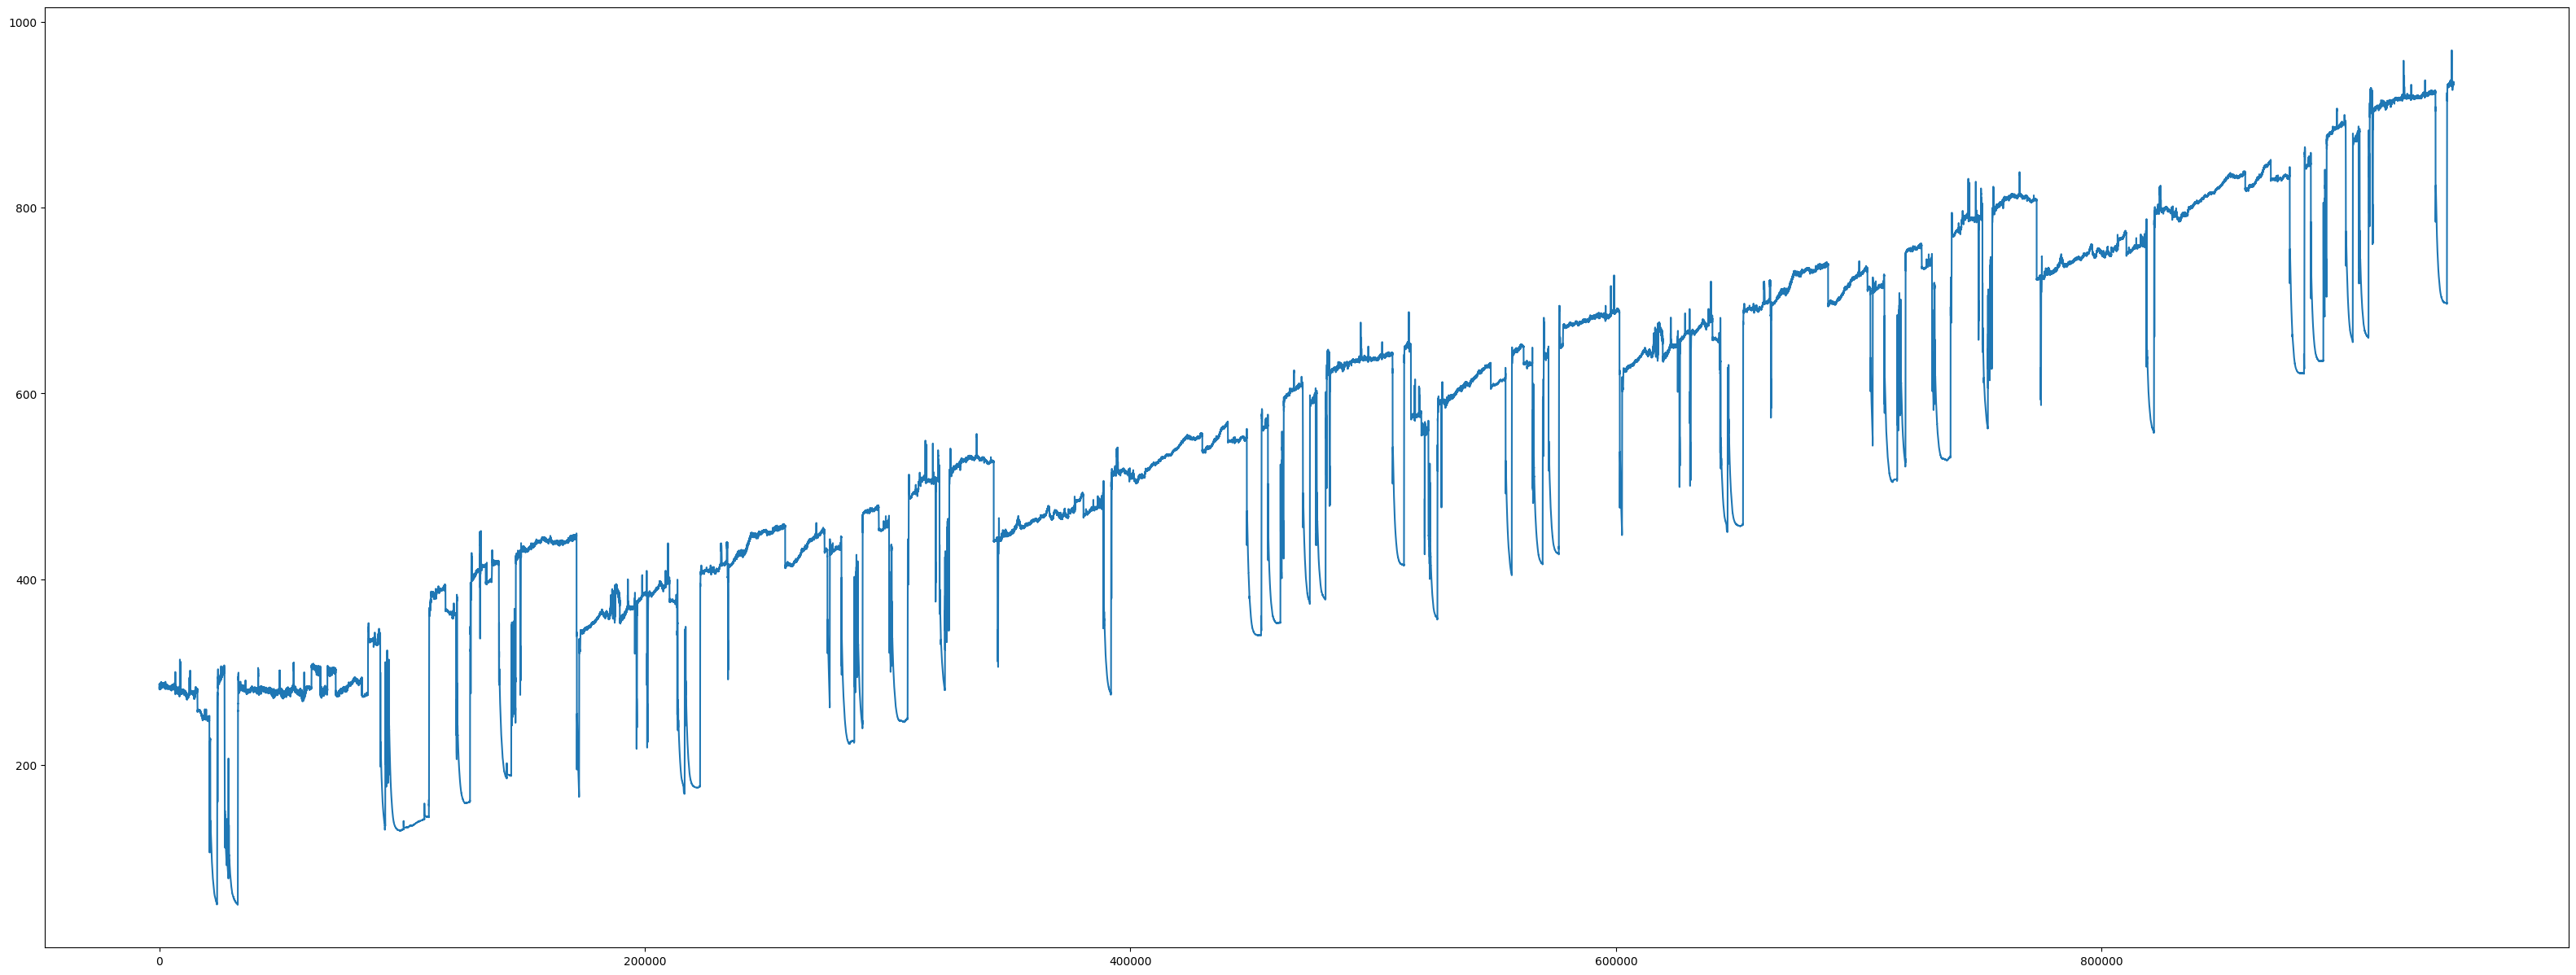

In [40]:
plt.figure(figsize=(40,15))
plt.plot(range(len(df_temp_all)), df_temp_all['TEMP'])

In [41]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
df_temp_all['TEMP'] = min_max_scaler.fit_transform(df_temp_all['TEMP'].to_numpy().reshape(-1,1))

In [42]:
from torch.utils.data import DataLoader, Dataset
class windowDataset(Dataset):
    def __init__(self, y, input_window=80, output_window=20, stride=5):
        L = y.shape[0]
        num_samples = (L - input_window - output_window) // stride + 1

        X = np.zeros([input_window, num_samples])
        Y = np.zeros([output_window, num_samples])

        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + input_window
            X[:,i] = y[start_x:end_x]

            start_y = stride*i + input_window
            end_y = start_y + output_window
            Y[:,i] = y[start_y:end_y]

        X = X.reshape(X.shape[0], X.shape[1], 1).transpose((1,0,2))
        Y = Y.reshape(Y.shape[0], Y.shape[1], 1).transpose((1,0,2))
        self.x = X
        self.y = Y
        
        self.len = len(X)
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    def __len__(self):
        return self.len

In [43]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
df_temp_all['TEMP'] = min_max_scaler.fit_transform(df_temp_all['TEMP'].to_numpy().reshape(-1,1))

In [44]:
train_len = int(len(df_temp_all)*0.8)
train = df_temp_all[:train_len]
test = df_temp_all[train_len:]

data_train = train['TEMP'].to_numpy()
data_test = test['TEMP'].to_numpy()

In [45]:
len(data_train)

756096

In [46]:
len(data_test)

189024

In [47]:
iw = 60
ow = 2

train_dataset = windowDataset(data_train, input_window=iw, output_window=ow, stride=30)
train_loader = DataLoader(train_dataset, batch_size=8)

In [48]:
from torch.nn import Transformer
from torch import nn
import torch
import math

class TFModel(nn.Module):
    def __init__(self,d_model, nhead, nhid, nlayers, dropout=0.5):
        super(TFModel, self).__init__()
        self.transformer = Transformer(d_model=d_model, nhead=nhead, dim_feedforward=nhid, num_encoder_layers=nlayers, num_decoder_layers=nlayers,dropout=dropout)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        self.pos_encoder_d = PositionalEncoding(d_model, dropout)
        self.linear = nn.Linear(d_model, 1)
        self.encoder = nn.Linear(1, d_model)
        self.encoder_d = nn.Linear(1, d_model)

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, src, tgt, srcmask, tgtmask):
        src = self.encoder(src)
        src = self.pos_encoder(src)

        tgt = self.encoder_d(tgt)
        tgt = self.pos_encoder_d(tgt)
        output = self.transformer(src.transpose(0,1), tgt.transpose(0,1), srcmask, tgtmask)
        output = self.linear(output)
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

def gen_attention_mask(x):
    mask = torch.eq(x, 0)
    return mask

In [49]:
device = torch.device("cuda")

lr = 1e-3
model = TFModel(256, 8, 256, 2, 0.1).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [50]:
epoch = 2000
from tqdm import tqdm

model.train()
progress = tqdm(range(epoch))
for i in progress:
    batchloss = 0.0
    
    for (inputs, dec_inputs, outputs) in train_loader:
        optimizer.zero_grad()
        src_mask = model.generate_square_subsequent_mask(inputs.shape[1]).to(device)
        tgt_mask = model.generate_square_subsequent_mask(dec_inputs.shape[1]).to(device)

        result = model(inputs.float().to(device), dec_inputs.float().to(device), src_mask, tgt_mask)
        loss = criterion(result.permute(1,0,2), outputs.float().to(device))
        
        loss.backward()
        optimizer.step()
        batchloss += loss
    progress.set_description("{:0.5f}".format(batchloss.cpu().item() / len(train_loader)))

  0%|          | 0/2000 [00:00<?, ?it/s]


ValueError: not enough values to unpack (expected 3, got 2)